In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy.stats import norm


%matplotlib inline


In [170]:
condos = pd.read_csv('condos.csv')

In [44]:
condos.head()

,SSL_condo,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,WARD,ZIPCODE,LATITUDE,LONGITUDE,QUADRANT,RES_TYPE,APPRAISED_VALUE_CURRENT_TOTAL
0,0025 2295,2006,2006,4,1,2,0,8.0,1.0,0,1161,Ward 2,20037.0,38.904239,-77.052353,NW,RESIDENTIAL,919910.0
1,0025 2296,2006,2006,4,2,2,0,8.0,1.0,0,1047,Ward 2,20037.0,38.904239,-77.052353,NW,RESIDENTIAL,847580.0
2,0025 2297,2006,2006,4,2,2,0,8.0,1.0,0,1291,Ward 2,20037.0,38.904239,-77.052353,NW,RESIDENTIAL,970460.0
3,0025 2298,2006,2006,4,1,1,0,8.0,1.0,0,805,Ward 2,20037.0,38.904239,-77.052353,NW,RESIDENTIAL,678120.0
4,0025 2300,2006,2006,3,1,1,0,8.0,1.0,0,750,Ward 2,20037.0,38.904239,-77.052353,NW,RESIDENTIAL,601160.0


In [171]:
#master7 = master7.reset_index()
condos.dropna(inplace=True)

catfeat= ["WARD", "QUADRANT", "ZIPCODE", 'RES_TYPE', "HEAT"]


encoded_df = pd.get_dummies(data = condos, columns = catfeat)
x_data = encoded_df.drop(['SSL_condo','APPRAISED_VALUE_CURRENT_TOTAL'], axis = 1)
y_data = encoded_df['APPRAISED_VALUE_CURRENT_TOTAL']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.20, random_state=679)
encoded_df.head()

,SSL_condo,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,AC,FIREPLACES,Living_SqFt,...,HEAT_4.0,HEAT_5.0,HEAT_6.0,HEAT_7.0,HEAT_8.0,HEAT_9.0,HEAT_10.0,HEAT_11.0,HEAT_12.0,HEAT_13.0
0,0025 2295,2006,2006,4,1,2,0,1.000000,0,1161,...,0,0,0,0,1,0,0,0,0,0
1,0025 2296,2006,2006,4,2,2,0,1.000000,0,1047,...,0,0,0,0,1,0,0,0,0,0
2,0025 2297,2006,2006,4,2,2,0,1.000000,0,1291,...,0,0,0,0,1,0,0,0,0,0
3,0025 2298,2006,2006,4,1,1,0,1.000000,0,805,...,0,0,0,0,1,0,0,0,0,0
4,0025 2300,2006,2006,3,1,1,0,1.000000,0,750,...,0,0,0,0,1,0,0,0,0,0


I first encode all categorical variables, then split it into test/train datasets. The first model will be linear regression. I will try normalizing the input variables.

In [5]:
sc = StandardScaler()
x_train_norm = sc.fit_transform(x_train)
x_test_norm = sc.fit_transform(x_test)

In [6]:
 
lr = LinearRegression()
lr.fit(x_train_norm, y_train)
print(lr.intercept_, lr.score(x_train_norm, y_train))

predictions_lr = lr.predict(x_test_norm)
lin_mse = mean_squared_error(y_test, predictions_lr) 
lin_rmse = np.sqrt(lin_mse) 
lin_rmse


463966.4009844018 0.8239945257826844


633446865436561.6

In [7]:
lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.intercept_, lr.score(x_train, y_train))

predictions_lr = lr.predict(x_test)
lin_mse = mean_squared_error(y_test, predictions_lr) 
lin_rmse = np.sqrt(lin_mse) 
lin_rmse

-47343849.377918065 0.8239945569169407


84372.23093473601

The normalized model has an obcene RSME; something is wrong, but I can't figure out what. The non-normalized model has an RMSE of $84,372 which is not the best. Let's try the following models to see if we can find anything better: gradient booster and random forest.

In [8]:
model_gb = ensemble.GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2,                                                                              learning_rate=0.1, loss='ls')
# Train the model on the training data.
model_gb.fit(x_train, y_train)

#print(model_gb.intercept_, model_gb.score(x_train_norm, y_train))

# Make predictions on the model using the test data.
predictions_gb = model_gb.predict(x_test)

lin_mse = mean_squared_error(y_test, predictions_gb) 
lin_rmse = np.sqrt(lin_mse) 
lin_rmse

52099.13163658322

In [9]:
param_grid = [
    # Try 12 (3×4) combinations of hyperparameters.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # Try 6 (2×3) combinations and set bootstrap to False.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
rfg = RandomForestRegressor(random_state=482)
# Train across 5 folds, that's a total of (12+6)*5=90 rounds of training. 
grid_search = GridSearchCV(rfg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [172]:
model_rf = RandomForestRegressor(n_estimators=30, max_features=8, random_state=482)   
# Train the model on the training data.
model_rf.fit(x_train, y_train)
# Make predictions on the model using the test data.
predictions_rf = model_rf.predict(x_test)
lin_mse = mean_squared_error(y_test, predictions_rf) 
lin_rmse = np.sqrt(lin_mse) 
lin_rmse


50434.81175581817

In [173]:
importances = {}
columns = list(x_train.columns)
features = list(model_rf.feature_importances_)
listicle = sorted(list(zip(columns,features)), key=lambda a: a[1], reverse=True)
top_15_features = listicle[:15]

keys = []
values = []
for i in top_15_features:
    keys.append(i[0])
    values.append(i[1])

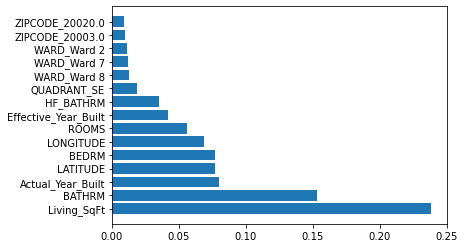

In [177]:
plt.barh(keys, values)
plt.savefig('random forest importances.png',bbox_inches='tight')


In [193]:
i = 0
tot_imp = 0
while i < 15:
    if values[i] > 0.05:
        print(keys[i], 
              values[i])
        tot_imp += values[i]
    i += 1
print(tot_imp)

Living_SqFt 0.23813937660110404
BATHRM 0.1528760888752331
Actual_Year_Built 0.07999743493652292
LATITUDE 0.07703950673226406
BEDRM 0.07672680444162588
LONGITUDE 0.0683806845712465
ROOMS 0.05632821679619178
0.7494881129541882


In [11]:
confidence = 0.95
squared_errors = (predictions_rf - y_test) ** 2
print(squared_errors.mean())
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

2543670236.8448253


array([47507.61605385, 53201.19256717])

Random forest has the best RMSE of \\$50,434, with a confidence interval of +/- \\$2,766. The RMSE is the standard deviation of the prediction, meaning units with identical featuers ~\\$50,000 less than the prediction are in the bottom 16% of unit prices and are a 'good' deal and those ~\\$50,000 greater in the upper 16% of unit prices and are a 'bad' deal.   

https://data4help.medium.com/predicting-real-estate-prices-255266ce2f43

For future analysis, 16% is a strange cutoff; let's say that a good deal is in the bottom 1/3 of prices and a great deal is in the bottom quarter. Those values can be calculated as follows:

In [12]:

print('Bottom third: ', norm.ppf(.33, loc = 50434.81175581817, scale = 53201.19256717-47507.61605385))

print('Bottom quarter: ', norm.ppf(.25, loc = 50434.81175581817, scale = 53201.19256717-47507.61605385))


Bottom third:  47930.13248784079
Bottom quarter:  46594.55275562668


## New model: Anacostia + the rest

In [106]:
anacostia = condos.loc[condos['WARD'].isin(['Ward 7','Ward 8'])]
non_anacostia = condos.loc[~condos['WARD'].isin(['Ward 7','Ward 8'])]

anacostia.dropna(inplace=True)
non_anacostia.dropna(inplace=True)

catfeat= ["QUADRANT", "ZIPCODE", 'RES_TYPE', "HEAT"]

a_encoded = pd.get_dummies(data = anacostia, columns = catfeat)
n_encoded = pd.get_dummies(data = non_anacostia, columns = catfeat)

a_x_data = a_encoded.drop(['SSL_condo','APPRAISED_VALUE_CURRENT_TOTAL', 'WARD'], axis = 1)
a_y_data = a_encoded['APPRAISED_VALUE_CURRENT_TOTAL']

n_x_data = n_encoded.drop(['SSL_condo','APPRAISED_VALUE_CURRENT_TOTAL', 'WARD'], axis = 1)
n_y_data = n_encoded['APPRAISED_VALUE_CURRENT_TOTAL']

a_x_train, a_x_test, a_y_train, a_y_test = train_test_split(a_x_data, a_y_data, 
                                                            test_size = 0.20, random_state=679)
n_x_train, n_x_test, n_y_train, n_y_test = train_test_split(n_x_data, n_y_data, 
                                                            test_size = 0.20, random_state=679)
#a_x_data.head(25)

<ipython-input-106-38d6b71b3606>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anacostia.dropna(inplace=True)
<ipython-input-106-38d6b71b3606>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_anacostia.dropna(inplace=True)


In [107]:
param_grid = [
    # Try 12 (3×4) combinations of hyperparameters.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # Try 6 (2×3) combinations and set bootstrap to False.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
rfg = RandomForestRegressor(random_state=482)
# Train across 5 folds, that's a total of (12+6)*5=90 rounds of training. 
grid_search = GridSearchCV(rfg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(a_x_train, a_y_train)
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [109]:
model_rf = RandomForestRegressor(n_estimators=30, max_features=6, random_state=482)   
# Train the model on the training data.
model_rf.fit(a_x_train, a_y_train)
# Make predictions on the model using the test data.
predictions_rf = model_rf.predict(a_x_test)
lin_mse = mean_squared_error(a_y_test, predictions_rf) 
lin_rmse = np.sqrt(lin_mse) 
lin_rmse


26428.984689885005

In [110]:
param_grid = [
    # Try 12 (3×4) combinations of hyperparameters.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # Try 6 (2×3) combinations and set bootstrap to False.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
rfg = RandomForestRegressor(random_state=482)
# Train across 5 folds, that's a total of (12+6)*5=90 rounds of training. 
grid_search = GridSearchCV(rfg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(n_x_train, n_y_train)
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [111]:
model_rf = RandomForestRegressor(n_estimators=30, max_features=8, random_state=482)   
# Train the model on the training data.
model_rf.fit(n_x_train, n_y_train)
# Make predictions on the model using the test data.
predictions_rf = model_rf.predict(n_x_test)
lin_mse = mean_squared_error(n_y_test, predictions_rf) 
lin_rmse = np.sqrt(lin_mse) 
lin_rmse


51256.06841810635

In [113]:
(51256.06841810635 * len(non_anacostia) + 26428.984689885005 * len(anacostia)) / len(condos)

48826.32837815515

In [116]:
grid_search.best_params_['n_estimators']

30

In [139]:
wards = ['Ward 1', 'Ward 2', 'Ward 3', 'Ward 4', 'Ward 5', 'Ward 6', 'Ward 7', 'Ward 8']

msres = []
lens = []
ward_import = {'Ward 1': (), 'Ward 2': (), 'Ward 3': (), 'Ward 4': (), 
               'Ward 5': (), 'Ward 6': (), 'Ward 7': (), 'Ward 8': ()}


for wardnum in wards:
    print(wardnum)
    ward = condos.loc[condos['WARD'].isin([str(wardnum)])]

    ward.dropna(inplace=True)

    catfeat= ["QUADRANT", "ZIPCODE", 'RES_TYPE', "HEAT"]

    encoded = pd.get_dummies(data = ward, columns = catfeat)

    x_data = encoded.drop(['SSL_condo','APPRAISED_VALUE_CURRENT_TOTAL', 'WARD'], axis = 1)
    y_data = encoded['APPRAISED_VALUE_CURRENT_TOTAL']

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.20, random_state=679)
    
    param_grid = [
        # Try 12 (3×4) combinations of hyperparameters.
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        # Try 6 (2×3) combinations and set bootstrap to False.
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
      ]
    rfg = RandomForestRegressor(random_state=482)
    # Train across 5 folds, that's a total of (12+6)*5=90 rounds of training. 
    grid_search = GridSearchCV(rfg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)
    grid_search.fit(x_train, y_train)
    
    model_rf = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'], 
                                     max_features=grid_search.best_params_['max_features'], 
                                     random_state=482)   
    # Train the model on the training data.
    model_rf.fit(x_train, y_train)
    # Make predictions on the model using the test data.
    predictions_rf = model_rf.predict(x_test)
    lin_mse = mean_squared_error(y_test, predictions_rf) 
    lin_rmse = np.sqrt(lin_mse) 
    msres.append(lin_rmse)
    lens.append(len(ward))
    
    importances = {}
    columns = list(x_train.columns)
    features = list(model_rf.feature_importances_)
    listicle = sorted(list(zip(columns,features)), key=lambda a: a[1], reverse=True)
    top_15_features = listicle[:15]

    keys = []
    values = []
    for i in top_15_features:
        keys.append(i[0])
        values.append(i[1])
    ward_import[wardnum] = ((keys, values))

    

Ward 1


<ipython-input-139-6287dd3f9afa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.dropna(inplace=True)


Ward 2


<ipython-input-139-6287dd3f9afa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.dropna(inplace=True)


Ward 3


<ipython-input-139-6287dd3f9afa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.dropna(inplace=True)


Ward 4


<ipython-input-139-6287dd3f9afa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.dropna(inplace=True)


Ward 5


<ipython-input-139-6287dd3f9afa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.dropna(inplace=True)


Ward 6


<ipython-input-139-6287dd3f9afa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.dropna(inplace=True)


Ward 7


<ipython-input-139-6287dd3f9afa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.dropna(inplace=True)


Ward 8


<ipython-input-139-6287dd3f9afa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.dropna(inplace=True)


In [132]:
print(msres)
print(lens)

[56254.42912910022, 47968.928406358646, 28614.09318078663, 53143.25893781313, 50097.724448593675, 73199.71443103616, 26804.47613331213, 22770.246067322936]
[8169, 11563, 6064, 2258, 3233, 5585, 2004, 1996]


In [133]:
pooled_error = 0
for i in range(len(msres)):
    pooled_error += msres[i] * lens[i]
pooled_error/len(condos)

48386.974457070646

In [196]:
for wardnum in wards:
    print('\n', wardnum)
    i = 0
    tot_imp = 0
    while i < 15:
        if ward_import[wardnum][1][i] > 0.05:
            print(ward_import[wardnum][0][i], 
                  ward_import[wardnum][1][i])
            tot_imp += ward_import[wardnum][1][i]
        i += 1
    print(tot_imp)

    #plt.barh(ward_import[wardnum][0], ward_import[wardnum][1])
    #plt.show()



 Ward 1
Living_SqFt 0.44408841186238035
BATHRM 0.19135153975299432
BEDRM 0.09310178408456889
ROOMS 0.0694990323719967
LATITUDE 0.054021018078720326
0.8520617861506606

 Ward 2
Living_SqFt 0.3425683154010749
BEDRM 0.1386520141881987
BATHRM 0.12573017743296735
ROOMS 0.12370498390697623
Actual_Year_Built 0.0881907956963181
0.8188462866255353

 Ward 3
Living_SqFt 0.3162437669123705
BATHRM 0.23167465309991744
BEDRM 0.10649865017375923
Actual_Year_Built 0.09779017120476902
Effective_Year_Built 0.08328872271786454
0.8354959641086809

 Ward 4
Living_SqFt 0.31836699089881115
BATHRM 0.18836556667271764
BEDRM 0.12699435279140364
LATITUDE 0.0844522868807412
ROOMS 0.06681500107725828
Actual_Year_Built 0.05212838969862085
0.8371225880195527

 Ward 5
Living_SqFt 0.3201541441806439
BATHRM 0.16417435277915257
LONGITUDE 0.0940732293666217
BEDRM 0.09205488075289742
ROOMS 0.07271132154134424
Actual_Year_Built 0.057430851701854684
LATITUDE 0.055583969669048244
0.8561827499915627

 Ward 6
Living_SqFt 0.383

In [161]:
ward1 = condos.loc[condos['WARD'].isin(['Ward 1'])]
ward2 = condos.loc[condos['WARD'].isin(['Ward 2'])]
ward3 = condos.loc[condos['WARD'].isin(['Ward 3'])]
ward4 = condos.loc[condos['WARD'].isin(['Ward 4'])]
ward5 = condos.loc[condos['WARD'].isin(['Ward 5'])]
ward6 = condos.loc[condos['WARD'].isin(['Ward 6'])]
ward7 = condos.loc[condos['WARD'].isin(['Ward 7'])]
ward8 = condos.loc[condos['WARD'].isin(['Ward 8'])]


In [199]:
(ward7['APPRAISED_VALUE_CURRENT_TOTAL'].mean() * len(ward7) + 
ward8['APPRAISED_VALUE_CURRENT_TOTAL'].mean() * len(ward8)) / (len(ward7) + len(ward8))

242731.61375

In [201]:
(ward1['APPRAISED_VALUE_CURRENT_TOTAL'].mean() * len(ward1) + 
 ward2['APPRAISED_VALUE_CURRENT_TOTAL'].mean() * len(ward2) +  
 ward3['APPRAISED_VALUE_CURRENT_TOTAL'].mean() * len(ward3) +  
 ward4['APPRAISED_VALUE_CURRENT_TOTAL'].mean() * len(ward4) +  
 ward5['APPRAISED_VALUE_CURRENT_TOTAL'].mean() * len(ward5) +  
 ward6['APPRAISED_VALUE_CURRENT_TOTAL'].mean() * len(ward6)) / (len(ward1) + len(ward2) + len(ward3) + 
                                                                len(ward4) + len(ward5) + len(ward6))

488349.77332393144

In [162]:
ward1.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
count,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000,8169.000000
mean,1949.879422,1952.057290,3.821276,1.568613,1.481454,0.161219,4.691639,0.914555,0.171012,867.635818,20008.418411,38.924272,-77.034325,538504.408128
std,44.311782,40.868158,0.919845,0.702050,0.551847,0.367756,4.055658,0.279560,0.376543,329.575472,2.579392,0.005604,0.007294,184989.732037
min,1880.000000,1890.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,209.000000,20001.000000,38.914293,-77.048537,75820.000000
25%,1910.000000,1924.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,610.000000,20009.000000,38.919325,-77.039979,390810.000000
50%,1927.000000,1926.000000,4.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,821.000000,20009.000000,38.922959,-77.033946,518480.000000
75%,2005.000000,2005.000000,4.000000,2.000000,2.000000,0.000000,8.000000,1.000000,0.000000,1068.000000,20010.000000,38.929126,-77.029212,664950.000000
max,2021.000000,2021.000000,6.000000,3.000000,3.000000,1.000000,13.000000,1.000000,1.000000,2317.000000,20010.000000,38.937015,-77.014749,1045000.000000


In [163]:
ward2.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
count,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000,11563.000000
mean,1963.469601,1964.122287,3.358212,1.170803,1.292831,0.113811,5.071954,0.948802,0.186111,778.517426,20013.861628,38.907163,-77.036720,513790.490530
std,42.086095,40.315744,0.901396,0.706291,0.465974,0.317596,3.630462,0.220410,0.389213,281.578259,14.200313,0.005349,0.011302,192378.948349
min,1820.000000,1820.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,199.000000,20001.000000,38.893299,-77.070053,55570.000000
25%,1925.000000,1924.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,560.000000,20005.000000,38.904617,-77.046261,374060.000000
50%,1973.000000,1968.000000,3.000000,1.000000,1.000000,0.000000,7.000000,1.000000,0.000000,735.000000,20007.000000,38.907462,-77.036078,484170.000000
75%,2004.000000,2004.000000,4.000000,2.000000,2.000000,0.000000,8.000000,1.000000,0.000000,950.000000,20036.000000,38.910910,-77.027800,641720.000000
max,2021.000000,2021.000000,6.000000,3.000000,3.000000,1.000000,13.000000,1.000000,1.000000,2412.000000,20037.000000,38.918234,-77.015489,1049050.000000


In [164]:
ward3.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
count,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000
mean,1959.026880,1958.418206,3.658476,1.253133,1.252474,0.103397,5.619888,0.857685,0.092348,871.509565,20011.362632,38.934855,-77.073123,410383.822559
std,23.710980,24.296846,0.978214,0.662419,0.446819,0.304502,4.329700,0.349402,0.289541,332.168898,4.152653,0.011095,0.010072,160081.695406
min,1900.000000,1900.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,274.000000,20007.000000,38.908331,-77.102180,144540.000000
25%,1942.000000,1942.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,644.000000,20008.000000,38.926861,-77.080823,293755.000000
50%,1959.000000,1959.000000,4.000000,1.000000,1.000000,0.000000,7.000000,1.000000,0.000000,785.000000,20008.000000,38.933175,-77.075134,369030.000000
75%,1968.000000,1968.000000,4.000000,2.000000,1.000000,0.000000,8.000000,1.000000,0.000000,1051.000000,20016.000000,38.939990,-77.067010,491495.000000
max,2022.000000,2022.000000,6.000000,3.000000,3.000000,1.000000,13.000000,1.000000,1.000000,2618.000000,20016.000000,38.962619,-77.051998,1048760.000000


In [165]:
ward4.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
count,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000,2258.000000
mean,1960.176262,1962.549601,3.792737,1.690434,1.503100,0.178919,4.265279,0.938884,0.034544,859.943756,20011.144376,38.953208,-77.024990,422913.356953
std,42.035640,39.550044,0.827368,0.700849,0.587297,0.383370,3.750297,0.239596,0.182662,337.377179,0.433905,0.012449,0.006166,171227.181362
min,1900.000000,1900.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,252.000000,20010.000000,38.935241,-77.035140,60760.000000
25%,1925.000000,1925.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,627.000000,20011.000000,38.941224,-77.028996,298580.000000
50%,1940.000000,1940.000000,4.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,749.000000,20011.000000,38.955394,-77.026028,371725.000000
75%,2015.000000,2015.000000,4.000000,2.000000,2.000000,0.000000,8.000000,1.000000,0.000000,989.000000,20011.000000,38.958190,-77.021128,528452.500000
max,2022.000000,2022.000000,6.000000,3.000000,3.000000,1.000000,13.000000,1.000000,1.000000,2500.000000,20012.000000,38.983196,-77.010390,1046500.000000


In [166]:
ward5.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
count,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000
mean,1956.656666,1960.964120,3.883081,1.799876,1.596350,0.177544,3.356325,0.965048,0.051964,891.835756,20005.183112,38.916014,-76.997995,468119.653573
std,44.908202,40.401259,0.851216,0.712234,0.629866,0.382188,3.410612,0.183687,0.221989,354.193763,6.372162,0.010346,0.012114,178200.284214
min,1890.000000,1911.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,300.000000,20001.000000,38.899511,-77.017145,114600.000000
25%,1924.000000,1924.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,642.000000,20002.000000,38.908320,-77.008284,327280.000000
50%,1939.000000,1939.000000,4.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,780.000000,20002.000000,38.914225,-77.000936,440410.000000
75%,2015.000000,2015.000000,4.000000,2.000000,2.000000,0.000000,8.000000,1.000000,0.000000,1055.000000,20002.000000,38.921073,-76.986687,586210.000000
max,2022.000000,2022.000000,6.000000,3.000000,3.000000,1.000000,13.000000,1.000000,1.000000,2480.000000,20018.000000,38.952892,-76.952014,1047620.000000


In [167]:
ward6.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
count,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000
mean,1976.084691,1978.318174,3.505640,1.267144,1.292390,0.103133,4.808415,0.983169,0.102596,808.276634,20008.200537,38.888624,-77.005552,485137.724261
std,42.326544,37.942772,0.903280,0.696571,0.475685,0.304160,3.478933,0.128649,0.303458,288.545598,9.882851,0.010847,0.013076,169952.024354
min,1780.000000,1880.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,238.000000,20001.000000,38.864494,-77.024494,82060.000000
25%,1959.000000,1959.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,611.000000,20002.000000,38.879500,-77.017124,360680.000000
50%,2004.000000,2004.000000,3.000000,1.000000,1.000000,0.000000,7.000000,1.000000,0.000000,743.000000,20003.000000,38.886716,-77.010466,465020.000000
75%,2008.000000,2008.000000,4.000000,2.000000,2.000000,0.000000,8.000000,1.000000,0.000000,951.000000,20024.000000,38.900099,-76.991817,581350.000000
max,2021.000000,2021.000000,6.000000,3.000000,3.000000,1.000000,13.000000,1.000000,1.000000,2198.000000,20024.000000,38.906460,-76.982722,1047000.000000


In [168]:
ward7.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
count,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000
mean,1953.150699,1954.050898,3.922156,1.734531,1.285429,0.092814,5.275449,0.940120,0.043413,796.095309,20014.046906,38.882032,-76.955211,246322.906687
std,27.370942,26.293979,0.782311,0.633075,0.509880,0.290245,3.735779,0.237324,0.203836,279.543613,7.949654,0.012779,0.020059,183308.795591
min,1900.000000,1900.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,362.000000,20002.000000,38.857766,-76.983435,44130.000000
25%,1940.000000,1940.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,623.000000,20003.000000,38.867454,-76.977885,116657.500000
50%,1943.000000,1944.000000,4.000000,2.000000,1.000000,0.000000,8.000000,1.000000,0.000000,707.000000,20019.000000,38.885076,-76.951160,145045.000000
75%,1962.250000,1963.000000,4.000000,2.000000,2.000000,0.000000,8.000000,1.000000,0.000000,868.000000,20020.000000,38.891835,-76.937317,341900.000000
max,2021.000000,2021.000000,6.000000,3.000000,3.000000,1.000000,13.000000,1.000000,1.000000,2358.000000,20020.000000,38.908978,-76.913937,967680.000000


In [169]:
ward8.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
count,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,1975.919339,1976.254509,3.786573,1.698397,1.215431,0.077154,4.283066,0.970441,0.037575,813.081162,20020.712926,38.853668,-76.992570,239125.926854
std,29.681585,32.192705,0.834434,0.673313,0.413655,0.266903,3.649360,0.169410,0.190214,246.673511,10.446150,0.016410,0.012985,198925.890864
min,1852.000000,1900.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,376.000000,20003.000000,38.822270,-77.010946,41830.000000
25%,1953.000000,1952.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,655.000000,20020.000000,38.839382,-77.004370,104832.500000
50%,1965.000000,1965.000000,4.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,753.500000,20020.000000,38.856986,-76.995417,144005.000000
75%,2012.000000,2012.000000,4.000000,2.000000,1.000000,0.000000,8.000000,1.000000,0.000000,880.250000,20032.000000,38.864152,-76.984126,335150.000000
max,2020.000000,2020.000000,6.000000,3.000000,3.000000,1.000000,13.000000,1.000000,1.000000,1948.000000,20032.000000,38.877779,-76.963454,1023250.000000


In [202]:
ward8.head()

,SSL_condo,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Living_SqFt,WARD,ZIPCODE,LATITUDE,LONGITUDE,QUADRANT,RES_TYPE,APPRAISED_VALUE_CURRENT_TOTAL
14561,0700 2001,2020,2020,4,2,2,0,8.000000,1.000000,0,1122,Ward 8,20003.000000,38.875906,-77.008548,SE,RESIDENTIAL,677960.000000
14562,0700 2002,2020,2020,4,2,2,1,8.000000,1.000000,0,1122,Ward 8,20003.000000,38.875906,-77.008548,SE,RESIDENTIAL,677960.000000
14563,0700 2003,2020,2020,4,2,2,1,8.000000,1.000000,0,1122,Ward 8,20003.000000,38.875906,-77.008548,SE,RESIDENTIAL,677960.000000
14564,0700 2004,2020,2020,4,2,2,1,8.000000,1.000000,0,1122,Ward 8,20003.000000,38.875906,-77.008548,SE,RESIDENTIAL,677960.000000
14565,0700 2005,2020,2020,5,3,3,1,8.000000,1.000000,0,1877,Ward 8,20003.000000,38.875906,-77.008548,SE,RESIDENTIAL,748000.000000


In [203]:
zipcode = ward8.loc[ward8['ZIPCODE'].isin(['20003.000000'])]
nonzip = ward8.loc[~ward8['ZIPCODE'].isin(['20003.000000'])]
                     

In [204]:
print(zipcode['APPRAISED_VALUE_CURRENT_TOTAL'].mean())
print(nonzip['APPRAISED_VALUE_CURRENT_TOTAL'].mean())


568022.2493887531
154363.10649023316


In [205]:
print(len(zipcode))
print(len(nonzip))

409
1587
